In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("maracoos_01-20240805T1617.csv")
df

,time,m_ballast_pumped,m_pitch,m_pressure,density
0,2024-08-05T16:27:31Z,NaN,NaN,NaN,1024.70240
1,2024-08-05T16:27:31Z,NaN,NaN,NaN,NaN
2,2024-08-05T16:27:38Z,NaN,NaN,NaN,1024.69210
3,2024-08-05T16:27:39Z,NaN,NaN,2.4937,NaN
4,2024-08-05T16:27:43Z,NaN,0.399680,NaN,NaN
...,...,...,...,...,...
18716,2024-08-06T22:23:39Z,NaN,-0.446804,NaN,1022.71594
18717,2024-08-06T22:23:40Z,NaN,NaN,NaN,1020.51580
18718,2024-08-06T22:23:47Z,NaN,NaN,NaN,1020.51910
18719,2024-08-06T22:23:54Z,NaN,NaN,NaN,NaN


In [10]:
# Fill missing values using forward fill method
df_ffill = df.fillna(method='ffill')

# Or fill missing values using backward fill method
df_bfill = df.fillna(method='bfill')

# You can also combine both forward fill and backward fill to ensure all missing values are filled
df = df.fillna(method='ffill').fillna(method='bfill')

df.count()

/tmp/ipykernel_17337/2503049255.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ffill = df.fillna(method='ffill')
/tmp/ipykernel_17337/2503049255.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bfill = df.fillna(method='bfill')
/tmp/ipykernel_17337/2503049255.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


time                18721
m_ballast_pumped    18721
m_pitch             18721
m_pressure          18721
density             18721
dtype: int64

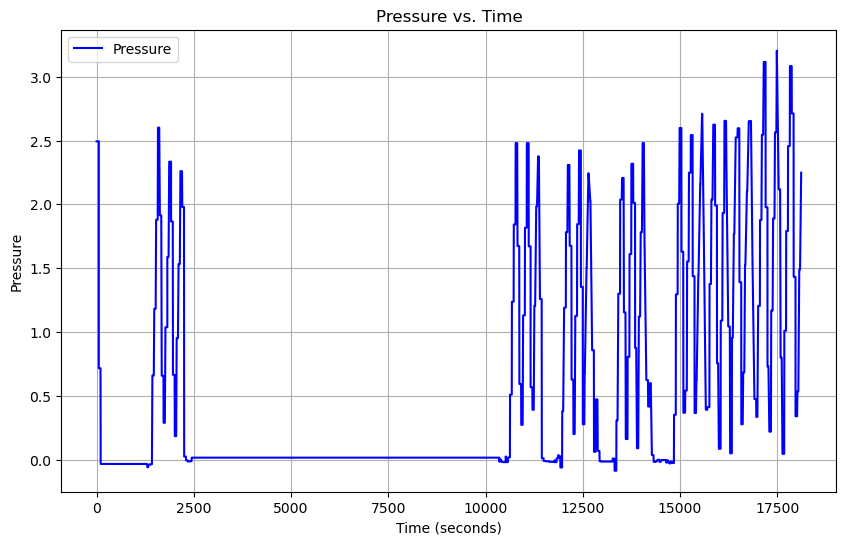

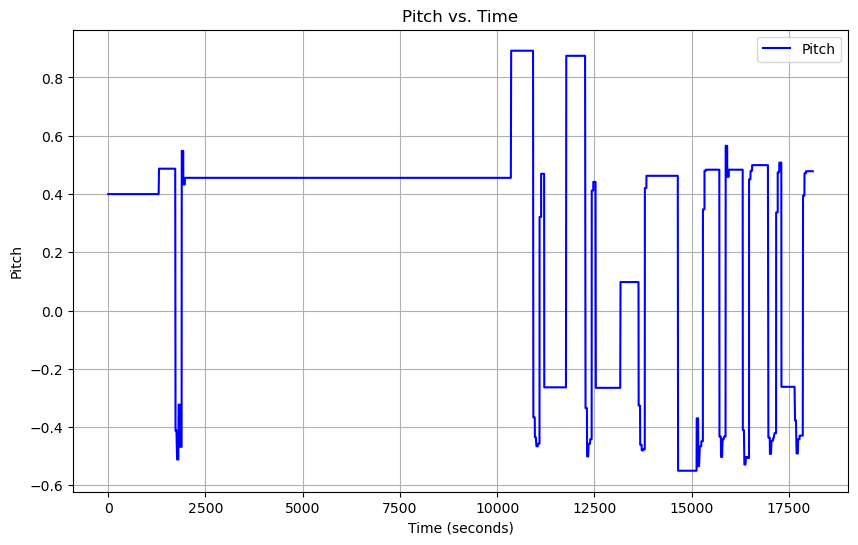

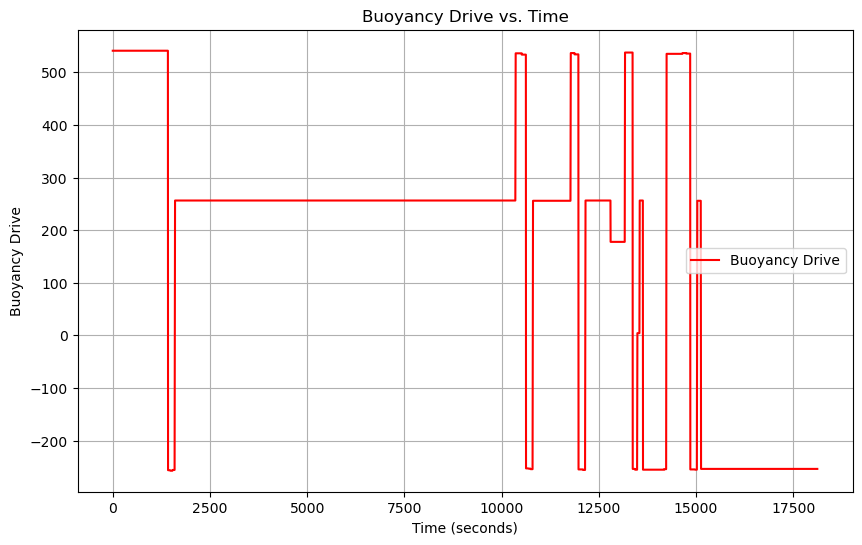

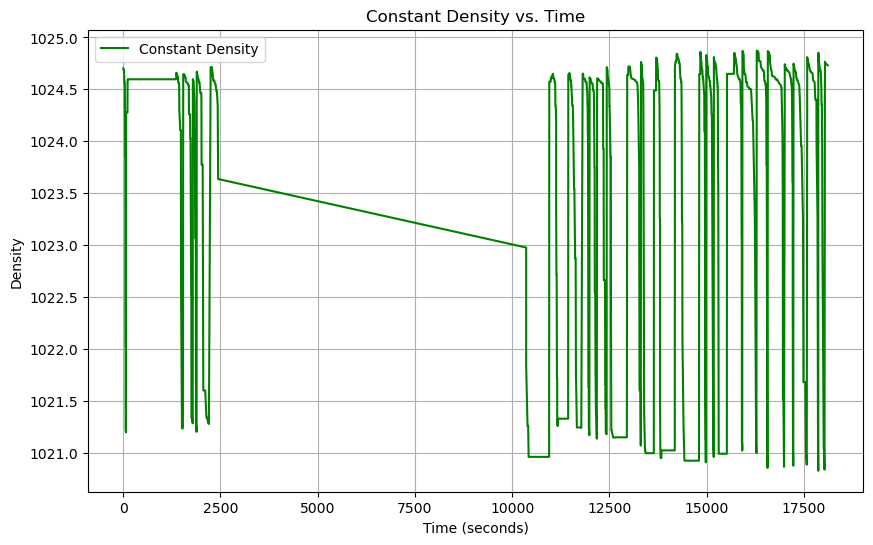

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def convert_volume_to_force(volume_cc, density, gravity=9.81):
    volume_m3 = volume_cc * 1e-6
    mass_water = volume_m3 * density
    buoyancy_force = mass_water * gravity
    return buoyancy_force

# Sample DataFrame creation (assuming df is already loaded)
# df = pd.read_csv('your_file.csv')  # Example of loading data

# Convert 'time' column to datetime, specify format if known
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Convert time to seconds since the first timestamp
df['time_seconds'] = (df['time'] - df['time'].iloc[0]).dt.total_seconds()

# Transform columns to float type
df['time_seconds'] = df['time_seconds'].astype(float)
df['m_pitch'] = df['m_pitch'].astype(float)
df['m_pressure'] = df['m_pressure'].astype(float)
df['m_ballast_pumped'] = df['m_ballast_pumped'].astype(float)
df['density'] = df['density'].astype(float)

# Assuming the volume in the problem statement is 56.3 liters,
# let's create a column for the buoyancy force in newtons
df['buoyancy_drive'] = df['m_ballast_pumped'].apply(lambda x: convert_volume_to_force(x, density=1000))

# Convert the selected columns to a NumPy array
array_data = df[['time_seconds', 'm_pressure', 'm_pitch', 'm_ballast_pumped', 'density']].to_numpy()

tctd = array_data[:1000, 0]
P = array_data[:1000, 1]
Pitch = array_data[:1000, 2]
buoyancy_drive = array_data[:1000, 3]
density = array_data[:1000, 4]

# Plot Pressure vs. Time
plt.figure(figsize=(10, 6))
plt.plot(tctd, P, label='Pressure', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Pressure')
plt.title('Pressure vs. Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot Pitch vs. Time
plt.figure(figsize=(10, 6))
plt.plot(tctd, Pitch, label='Pitch', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch')
plt.title('Pitch vs. Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot Buoyancy Drive vs. Time
plt.figure(figsize=(10, 6))
plt.plot(tctd, buoyancy_drive, label='Buoyancy Drive', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Buoyancy Drive')
plt.title('Buoyancy Drive vs. Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the constant density vector vs. Time
plt.figure(figsize=(10, 6))
plt.plot(tctd, density, label='Constant Density', color='green')
plt.xlabel('Time (seconds)')
plt.ylabel('Density')
plt.title('Constant Density vs. Time')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
import numpy as np
import sys
sys.path.insert(0, '..')
import gliderflight
import matplotlib.pyplot as plt
# Setup a steady-state model to calibrate
GM = gliderflight.SteadyStateCalibrate(rho0=1004)  # rho0 might be the initial density.
GM.define(ah=3.8, Cd1=10.5)    # ah: lift angle coefficient due to the hull (1/rad);  Cd1 is induced drag coefficient (1/rad²)
GM.set_input_data(time=tctd, pressure=P, pitch=Pitch, buoyancy_change=buoyancy_drive, density=density)
# GM.OR(P*10<10)
# GM.OR(P*10>100)
GM.define(Cd0=0.15, mg=58, Vg=56.3/1000)   # Cd0 is the parasite drag coefficient; mg: mass of the glider (kg); Vg: volume of the glider (m³)
calibration_result = GM.calibrate("Cd0", "mg", verbose=True)

/home/shengrenhuang/Codes/glider_trajectory_bootcamp/gliderflight/gliderflight.py:325: RuntimeWarning: divide by zero encountered in divide
  return -np.gradient(pressure*1e5)/np.gradient(time)/self.RHO0/self.G
/home/shengrenhuang/Codes/glider_trajectory_bootcamp/gliderflight/gliderflight.py:325: RuntimeWarning: invalid value encountered in divide
  return -np.gradient(pressure*1e5)/np.gradient(time)/self.RHO0/self.G
/home/shengrenhuang/Codes/glider_trajectory_bootcamp/gliderflight/gliderflight.py:643: RuntimeWarning: invalid value encountered in multiply
  self.modelresult = Modelresult(data["time"], ug, wg, U, alpha, pitch, ww, ww*0)


Error: 2.6817082e-01  -  Cd0=0.15  mg=58
Error: 2.6726279e-01  -  Cd0=0.1575  mg=58
Error: 3.8717138e-01  -  Cd0=0.15  mg=60.9
Error: 3.9937688e-01  -  Cd0=0.1575  mg=55.1
Error: 3.2479616e-01  -  Cd0=0.1519  mg=59.45
Error: 2.7914946e-01  -  Cd0=0.1556  mg=56.55
Error: 2.4242664e-01  -  Cd0=0.1547  mg=57.28
Error: 2.4241168e-01  -  Cd0=0.1622  mg=57.28
Error: 2.5158885e-01  -  Cd0=0.1683  mg=56.91
Error: 2.7807183e-01  -  Cd0=0.1594  mg=56.55
Error: 2.5001272e-01  -  Cd0=0.158  mg=57.64
Error: 2.5242398e-01  -  Cd0=0.1589  mg=56.91
Error: 2.4404851e-01  -  Cd0=0.1582  mg=57.46
Error: 2.4504469e-01  -  Cd0=0.1587  mg=57.09
Error: 2.4259049e-01  -  Cd0=0.1583  mg=57.37
Error: 2.4475240e-01  -  Cd0=0.1586  mg=57.18
Error: 2.4233161e-01  -  Cd0=0.1584  mg=57.32
Error: 2.4232711e-01  -  Cd0=0.1659  mg=57.32
Error: 2.4242110e-01  -  Cd0=0.1715  mg=57.34
Error: 2.4258531e-01  -  Cd0=0.1621  mg=57.37
Error: 2.4232017e-01  -  Cd0=0.1622  mg=57.3
Error: 2.4232034e-01  -  Cd0=0.1697  mg=57.3
Err

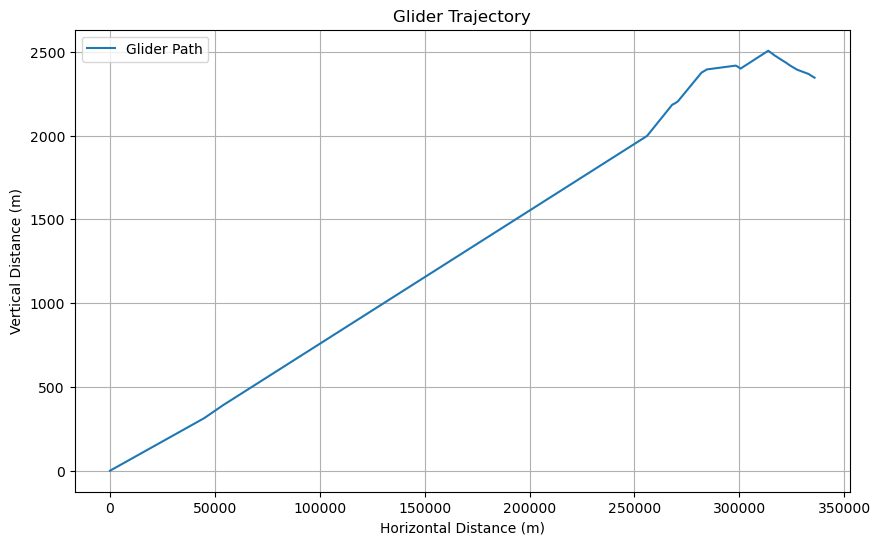

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure that pitch is in radians; if it's in degrees, convert it
pitch_rad = np.deg2rad(Pitch)  # If pitch is in degrees

# Assuming time intervals are uniform
dt = np.diff(GM.t, prepend=GM.t[0])

# Calculate vertical and horizontal velocity components
wg = GM.wg
ug = wg / np.tan(pitch_rad)

# Calculate displacement in horizontal and vertical directions
dx = ug * dt
dz = wg * dt

# Accumulate displacement to compute position
x = np.cumsum(dx)
z = np.cumsum(dz)

# Plot the trajectory
plt.figure(figsize=(10, 6))
plt.plot(x, z, label='Glider Path')
plt.xlabel('Horizontal Distance (m)')
plt.ylabel('Vertical Distance (m)')
plt.title('Glider Trajectory')
plt.legend()
plt.grid(True)
plt.show()
